https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

<AxesSubplot:xlabel='category'>

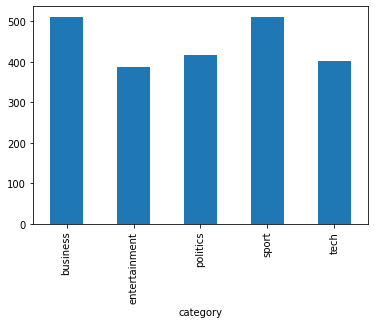

In [3]:
import pandas as pd
datapath = 'bbc-text.csv'
df = pd.read_csv(datapath)
df.head()
df.groupby(['category']).size().plot.bar()


In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [17]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])
bert_input.input_ids[0]

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


tensor([  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0])

In [6]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)


[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [7]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [9]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))


1780 222 223


In [10]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


In [11]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [01:42<00:00,  8.72it/s]


Epochs: 1 | Train Loss:  0.711                 | Train Accuracy:  0.430                 | Val Loss:  0.441                 | Val Accuracy:  0.887


100%|██████████| 890/890 [01:01<00:00, 14.42it/s]


Epochs: 2 | Train Loss:  0.289                 | Train Accuracy:  0.933                 | Val Loss:  0.167                 | Val Accuracy:  0.968


100%|██████████| 890/890 [01:03<00:00, 14.06it/s]


Epochs: 3 | Train Loss:  0.127                 | Train Accuracy:  0.979                 | Val Loss:  0.082                 | Val Accuracy:  0.995


100%|██████████| 890/890 [01:01<00:00, 14.45it/s]


Epochs: 4 | Train Loss:  0.072                 | Train Accuracy:  0.988                 | Val Loss:  0.049                 | Val Accuracy:  0.995


100%|██████████| 890/890 [01:02<00:00, 14.14it/s]


Epochs: 5 | Train Loss:  0.042                 | Train Accuracy:  0.993                 | Val Loss:  0.043                 | Val Accuracy:  0.991


In [21]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              
              
            
              print(tokenizer.decode(input_id[0]), output.argmax(dim=1), test_label)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


[CLS] chancellor rallies labour voters gordon brown has issued a rallying cry to supporters warning the stakes are too high to stay at home or protest vote in the next general election. the chancellor said the poll - expected to fall on 5 may - would give a clear and fundamental choice between labour investment and tory cuts. he told his party s spring conference the tories must not be allowed to win. the conservatives and lib dems insisted that voters faced higher taxes and means - testing under labour. to a packed audience at gateshead s sage centre mr brown accused shadow chancellor oliver letwin of plotting cuts that were the equivalent of sacking every teacher gp and nurse in the country. laying into the conservative s record in government he said : i give you this promise - with labour britain will never return to the mistakes of erm and 10 % inflation 15 % interest rates £3bn in lost reserves 250 000 repossessed one million in negative equity and three million unemployed. never 

[CLS] fast lifts rise into record books two high - speed lifts at the world s tallest building have been officially recognised as the planet s fastest. the lifts take only 30 seconds to whisk passengers to the top of the 508m tall tfc 101 tower in taipei taiwan. the guinness book of records has declared the 17m per second speed of the two lifts the swiftest on earth. the lifts also have a pressure control system to stop passengers ears popping as they ascend and descend at high speed. in total the tfc tower has 61 lifts 34 of them double - deckers and 50 escalators to shuttle people around its 106 floors. the tfc 101 tower is due to be officially opened on 31 december. the super - fast lifts can speed up to 24 passengers to the tip of the tower in about 30 seconds while ascending their 382m track. the 17m / s top speed of the lifts translates to about 38mph ( 61km / h ). curiously the lifts take longer to descend and spend almost a whole minute returning to ground level from the top of

[CLS] uk set to cut back on embassies nine overseas embassies and high commissions will close in an effort to save money uk foreign secretary jack straw has announced. the bahamas east timor madagascar and swaziland are among the areas affected by the biggest shake - up for the diplomatic service for years. other diplomatic posts are being turned over to local staff. mr straw said the move would save £6m a year to free up cash for priorities such as fighting terrorism. honorary consuls will be appointed in some of the areas affected by the embassy closures. nine consulates or consulates general will also be closed mostly in europe and america. they include dallas in the us bordeaux in france and oporto in portugal with local staff replacing uk representation in another 11. the changes are due to be put in place before the end of 2006 with most savings made from cutting staff and running costs. some of the money will have to be used to fund redundancy payments. in a written statement mr

[CLS] kennedy predicts bigger turnout voters pent up passion could confound predictions of a low turnout in the coming general election charles kennedy has said. the liberal democrat leader predicted concerns over iraq and other international and domestic issue would express themselves during the campaign. his comments come as an inquiry looks at how best to boost voter turnouts. ex - foreign secretary robin cook said people were not apathetic but fed up of pager politics and not being heard. he like mr kennedy pointed to the hundreds of thousands of people who demonstrated against plans for the iraq war. mr cook who is giving evidence to the power inquiry into voter turnout rates told bbc radio 4 s today programme it was not fair to blame the public who were more interested in politics than ever before. they are turned off by the way we do politics in britain. there s a message there for politicians. he urged politicians to avoid negative campaigning and to speak more from the heart. 

[CLS] klinsmann issues lehmann warning germany coach jurgen klinsmann has warned goalkeeper jens lehmann he may have to quit arsenal to keep his world cup dreams alive. lehmann is understudy to oliver kahn in the german squad but has lost his place to manuel alumnia at highbury. klinsmann said : it will be difficult for any of our players if he is not a first - choice at his club. if jens is not arsenal s number one keeper that is a problem for me. he must be playing regularly. lehmann is desperate to keep his place in the germany squad when the country hosts the world cup in 2006. klinsmann added : if he is not playing regularly he cannot be germany s number one keeper or even number two keeper. the situation for jens is that he is currently the number two keeper at arsenal. this could be critical if it remains the same during next season. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

[CLS] lib dems highlight problem debt people vulnerable to problem debts should be afforded greater protection from banks aggressively promoting financial products the lib dems say. vincent cable says one in eight households already struggle with debt and that will worsen if there is a hike in interest rates or unemployment. the lib dems treasury spokesman is unveiling a policy aimed at the issue. he wants to see proper health checks when loans are marketed so people know to take out payment protection. were economic conditions to deteriorate at all large numbers of people could be affected because they have borrowed to the limit mr cable told bbc news. banks are very aggressively promoting debt in many cases there is a bigger problem ahead. mr cable said the government s consumer credit bill would target some of the extreme problems such as loan sharking but ministers had been a bit complacent about the wider issue of debt levels. he said much of the payment protection currently avail

[CLS] housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12 % compared to last year. other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc2 for the first month since last july. however the channel s share of the audience fell from 11. 2 % to 9. 6 % last month in comparison with january 2004. celebrity big brother attracted less viewers than its 2002 series. comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date attracting a quarter of the television audience. the two main television channels bbc1 and itv1 have both seen their monthly audience share decline in a year on year comparison for january while five s proportion remained the same at a slender 6. 3 %. digital multi - channel tv is continuing to be the strongest area of growth with the bbc reporting freeview box ownership of five millio

[CLS] hewitt survives nalbandian epic home favourite lleyton hewitt came through a dramatic five - set battle with argentine david nalbandian to reach the australian open semi - finals. hewitt looked to be cruising to victory after racing into a two - set lead. but nalbandian broke his serve three times in both of the next two sets to set up a nailbiting decider. hewitt eventually grabbed the vital break in the 17th game and served out to win 6 - 3 6 - 2 1 - 6 3 - 6 10 - 8 and set up a meeting with andy roddick. the winner of that match will face either roger federer or marat safin in the final. ninth seed nalbandian had never come back from two sets down to win a match and there was no indication he would do so as hewitt dominated the first two sets. the argentine had stoked up the temperature ahead of the match by saying hewitt s exuberant on - court celebrations were not very good for the sport. and he had words with hewitt during one change of ends in the second set when the austra

[CLS] fuming robinson blasts officials england coach andy robinson insisted he was livid after his side were denied two tries in sunday s 19 - 13 six nations loss to ireland in dublin. mark cueto s first - half effort was ruled out for offside before the referee spurned tv replays when england crashed over in the dying minutes. [ i m ] absolutely spitting. i m livid. there s two tries we ve been cost robinson told bbc sport. we ve got to go back to technology. i don t know why we didn t. south african referee jonathan kaplan ruled that cueto was ahead of charlie hodgson when the fly - half hoisted his cross - field kick for the sale wing to gather. kaplan then declined the chance to consult the fourth official when josh lewsey took the ball over the irish line under a pile of bodies for what could have been the game - winning try. i think mark cueto scored a perfectly legal try and i think he should have gone to the video referee on josh lewsey said robinson. it is how we use the techn